<a href="https://colab.research.google.com/github/alfanugraha/mlzoomcamp-homework/blob/master/08_deep_learning_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

%matplotlib inline

## Seed Generators Setup

In [ ]:
import torch
import torchvision

import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preparation

Hair Type Dataset:
- https://www.kaggle.com/datasets/kavyasreeb/hair-type-dataset
- https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip

### Load image

Let's see the shape of an image from the dataset.

In [ ]:
path = './data/train/curly'
name = '00cbad1ffe22d900018e5a2e7376daed4.jpg'
fullname = f'{path}/{name}'
test_image = torchvision.io.read_image(fullname)
test_image.shape

torch.Size([3, 768, 614])

In [ ]:
img = mpimg.imread(fullname)
img.shape

(768, 614, 3)

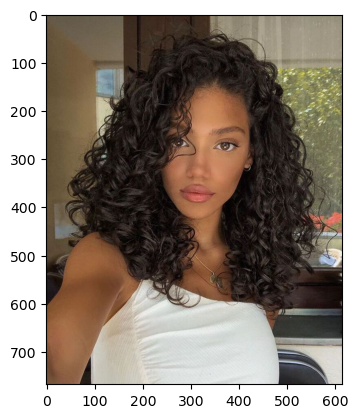

In [ ]:
img = Image.open(fullname).convert('RGB')
plt.imshow(img)

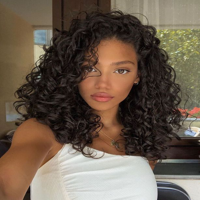

In [ ]:
img.resize((200, 200))

In [ ]:
# resize the input image to (200, 200)
train_transform = transforms.Compose([
    transforms.Resize(size = (200,200)),
    transforms.ToTensor()
])
x = train_transform(img)
x

tensor([[[0.3725, 0.3804, 0.3804,  ..., 0.5725, 0.5725, 0.5804],
         [0.3804, 0.3882, 0.3843,  ..., 0.5804, 0.5765, 0.5804],
         [0.3882, 0.3922, 0.3922,  ..., 0.5882, 0.5765, 0.5765],
         ...,
         [0.4549, 0.4588, 0.4627,  ..., 0.8627, 0.8667, 0.8745],
         [0.4588, 0.4667, 0.4667,  ..., 0.8667, 0.8706, 0.8667],
         [0.4667, 0.4706, 0.4667,  ..., 0.8549, 0.8667, 0.8667]],

        [[0.3373, 0.3451, 0.3451,  ..., 0.5529, 0.5529, 0.5608],
         [0.3412, 0.3490, 0.3451,  ..., 0.5608, 0.5569, 0.5608],
         [0.3412, 0.3490, 0.3451,  ..., 0.5686, 0.5569, 0.5569],
         ...,
         [0.3216, 0.3255, 0.3294,  ..., 0.8588, 0.8627, 0.8706],
         [0.3255, 0.3333, 0.3333,  ..., 0.8627, 0.8667, 0.8627],
         [0.3333, 0.3373, 0.3333,  ..., 0.8510, 0.8627, 0.8627]],

        [[0.2784, 0.2863, 0.2824,  ..., 0.4667, 0.4667, 0.4745],
         [0.2745, 0.2824, 0.2824,  ..., 0.4745, 0.4706, 0.4745],
         [0.2588, 0.2706, 0.2784,  ..., 0.4824, 0.4706, 0.

In [ ]:
x.shape

torch.Size([3, 200, 200])

We already have train and test for resize transformation.

- next, create a convolutional layer: 32 filters; 3x3 kernel size; 'relu' activation function
- reduce the size of the feature map with max pooling, set the pooling to (2, 2)
- turn the multi-dimensional result into vectors using `flatten` and `view`
- add nn.Linear with 64 neurons and relu activation function
- add nn.Linear with 1 neuron and activation function for binary classification

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(2,2)),
    torch.nn.Flatten(),

    torch.nn.Linear(32 * 99 * 99, 64),
    torch.nn.ReLU(),

    torch.nn.Linear(64, 1)
)

In [ ]:
# use torch.optim.SGD as optimizer with learning rate 0.002
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.002,
    momentum=0.8
)

## Q1. Loss function

In [ ]:
# define loss function for binary classification
criterion = torch.nn.BCEWithLogitsLoss()

## Q2. Number of parameters

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
           Flatten-4               [-1, 313632]               0
            Linear-5                   [-1, 64]      20,072,512
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 23.93
Params size (MB): 76.57
Estimated Total Size (MB): 100.96
----------------------------------------------------------------


Total parameters: `20,073,473`

## Q3. Median of training accuracy

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Load dataset

In [ ]:
train_dataset = ImageFolder(
    root = 'data/train',
    transform=train_transform
)

validation_dataset = ImageFolder(
    root = 'data/test',
    transform=test_transforms
)

Create DataLoader

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=20,
    shuffle=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=20,
    shuffle=False
)

Define device, loss function, and optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=313632, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6950, Acc: 0.5088, Val Loss: 0.6592, Val Acc: 0.6567
Epoch 2/10, Loss: 0.6686, Acc: 0.5962, Val Loss: 0.6232, Val Acc: 0.6418
Epoch 3/10, Loss: 0.6312, Acc: 0.6388, Val Loss: 0.7242, Val Acc: 0.6716
Epoch 4/10, Loss: 0.5924, Acc: 0.6750, Val Loss: 0.8010, Val Acc: 0.6816
Epoch 5/10, Loss: 0.5995, Acc: 0.6562, Val Loss: 0.7967, Val Acc: 0.6766
Epoch 6/10, Loss: 0.5659, Acc: 0.6987, Val Loss: 0.9405, Val Acc: 0.6567
Epoch 7/10, Loss: 0.5571, Acc: 0.6913, Val Loss: 0.7990, Val Acc: 0.6766
Epoch 8/10, Loss: 0.5481, Acc: 0.7150, Val Loss: 0.9822, Val Acc: 0.6716
Epoch 9/10, Loss: 0.5284, Acc: 0.7288, Val Loss: 1.1118, Val Acc: 0.6667
Epoch 10/10, Loss: 0.5191, Acc: 0.7338, Val Loss: 1.3011, Val Acc: 0.6318


In [ ]:
history['acc']

[0.50875,
 0.59625,
 0.63875,
 0.675,
 0.65625,
 0.69875,
 0.69125,
 0.715,
 0.72875,
 0.73375]

In [ ]:
med_acc = np.median(history['acc'])
med_acc

0.683125

## Q4. Standard deviation of training loss

In [ ]:
history['loss']

[0.6949532434344292,
 0.6686324089765548,
 0.6311634734272957,
 0.5924213632941246,
 0.5994888208806515,
 0.5659338034689426,
 0.5570818975567817,
 0.548106511682272,
 0.5284249410033226,
 0.5191301077604293]

In [ ]:
np.std(history['loss']).round(3)

0.056

## Q5. Mean of test loss

Generate more data using data augmentations

In [ ]:
# update train_transform
train_transforms = transforms.Compose([
    transforms.RandomRotation(50),                      # rotate images up to ±50 degrees
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),  # random crop & resize
    transforms.RandomHorizontalFlip(),                  # randomly flip horizontally
    transforms.Resize((200, 200)),                      # ensure final size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = ImageFolder(root='data/train', transform=train_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=20,
    shuffle=True
)

In [ ]:
# check model
model.train()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=313632, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
num_epochs_aug = 10
history_aug = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs_aug):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train

    history_aug['loss'].append(epoch_loss)
    history_aug['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val

    history_aug['val_loss'].append(val_epoch_loss)
    history_aug['val_acc'].append(val_epoch_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs_aug}, "
        f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
        f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
    )

Epoch 1/10, Loss: 0.6955, Acc: 0.6175, Val Loss: 0.6323, Val Acc: 0.6418
Epoch 2/10, Loss: 0.6062, Acc: 0.6825, Val Loss: 0.5951, Val Acc: 0.6667
Epoch 3/10, Loss: 0.5822, Acc: 0.6963, Val Loss: 0.5908, Val Acc: 0.6866
Epoch 4/10, Loss: 0.5797, Acc: 0.6863, Val Loss: 0.6126, Val Acc: 0.6368
Epoch 5/10, Loss: 0.5446, Acc: 0.7137, Val Loss: 0.7067, Val Acc: 0.6517
Epoch 6/10, Loss: 0.5553, Acc: 0.7125, Val Loss: 0.6018, Val Acc: 0.6468
Epoch 7/10, Loss: 0.5461, Acc: 0.6975, Val Loss: 0.6578, Val Acc: 0.6667
Epoch 8/10, Loss: 0.5375, Acc: 0.7125, Val Loss: 0.6237, Val Acc: 0.6368
Epoch 9/10, Loss: 0.5373, Acc: 0.7025, Val Loss: 0.6066, Val Acc: 0.6866
Epoch 10/10, Loss: 0.5315, Acc: 0.7325, Val Loss: 0.5990, Val Acc: 0.6567


In [ ]:
history_aug['val_loss']

[0.6322525449060089,
 0.5951236578362498,
 0.59080456590178,
 0.612577769886795,
 0.7067146582983026,
 0.601768434047699,
 0.6578477134752037,
 0.6236822403485502,
 0.6065598379320173,
 0.598979672389244]

In [ ]:
mean_val_loss = np.mean(history_aug['val_loss'])
mean_val_loss.round(3)

0.623

## Q6. Average of test accuracy for the last 5 epochs

In [ ]:
history_aug['val_acc']

[0.6417910447761194,
 0.6666666666666666,
 0.6865671641791045,
 0.6368159203980099,
 0.6517412935323383,
 0.6467661691542289,
 0.6666666666666666,
 0.6368159203980099,
 0.6865671641791045,
 0.6567164179104478]

In [ ]:
last_5_val_acc = history_aug['val_acc'][-5:]
last_5_val_acc

[0.6467661691542289,
 0.6666666666666666,
 0.6368159203980099,
 0.6865671641791045,
 0.6567164179104478]

In [ ]:
avg_last_5_val_acc = np.mean(last_5_val_acc)
avg_last_5_val_acc.round(3)

0.659

## Test the model on a single image

In [ ]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

x = transform(img)
x = x.unsqueeze(0)

In [ ]:
x.shape

torch.Size([1, 3, 200, 200])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x = x.to(device)
model.to(device)
model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=313632, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
with torch.no_grad():
    output = model(x)
    prob = torch.sigmoid(output)

print(f'{prob.item() * 100:.2f}%')

4.52%
